In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:

def power_spectrum(events, length, n_bins):
    omegas = [i/length for i in range(n_bins)]
    omega_exp = np.outer(events, omegas)
    complex_exp = np.exp(-1j * 2 * np.pi * omega_exp)
    spectrum = complex_exp.sum(axis=0)
    T = events[-1]
    power_spectrum = np.abs(spectrum)**2 / T
    return power_spectrum, omegas

def poisson_process(rate, T, rng=np.random.default_rng()):
    n_events = rng.poisson(rate*T)
    events = rng.uniform(0, T, n_events)
    events.sort()
    return events

def regular_poisson_process(rate, T, rng=np.random.default_rng()):
    n_events = int(rate*T)
    events = np.linspace(0, T, n_events, endpoint=False)
    events += rng.uniform(0, T/n_events/10, n_events)
    return events

from numpy.random import Generator, PCG64, exponential, choice
def intermittent_poisson_process(cluster_rate, intermission_rate, rng=Generator(PCG64(1)), n_total_events=int(1e4),
                                  max_events_in_cluster=10000, max_events_in_intermission=10000, z_on=-2.0, z_off=-2.0):

    events = np.zeros(n_total_events)

    n_distribution = np.power(np.arange(1, max_events_in_cluster+1), z_on)
    n_distribution = n_distribution / np.sum(n_distribution)

    m_distribution = np.power(np.arange(1, max_events_in_intermission+1), z_off)
    m_distribution = m_distribution / np.sum(m_distribution)

    t = 0.0
    i = 0
    state = True  # True = ON, False = OFF

    event_counter = choice(np.arange(1, max_events_in_cluster+1), p=n_distribution)

    while i < n_total_events:
        if state:
            # create next event
            dt = exponential(1.0/cluster_rate, size=1)
            t += dt
            events[i] = t
            i += 1
            event_counter -= 1

            if event_counter == 0:
                state = False
                event_counter = choice(np.arange(1, max_events_in_intermission+1), p=m_distribution)
        else:
            # create next event
            dt = exponential(1.0/intermission_rate, size=1)
            t += dt
            event_counter -= 1

            if event_counter == 0:
                state = True
                event_counter = choice(np.arange(1, max_events_in_cluster+1), p=n_distribution)

    return events


def plot_power_spectrum(events, min_omega, max_omega, n_bins):
    T = events[-1]/5
    power_spectrum_, omegas = power_spectrum(events, T, n_bins)
    s = power_spectrum_ * 0
    for i in range(1, 5):
        power_spectrum_, _ = power_spectrum(events[(events < i*T) * (events > (i-1)*T)], T, n_bins)
        s += power_spectrum_
    plt.plot(omegas, s)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()


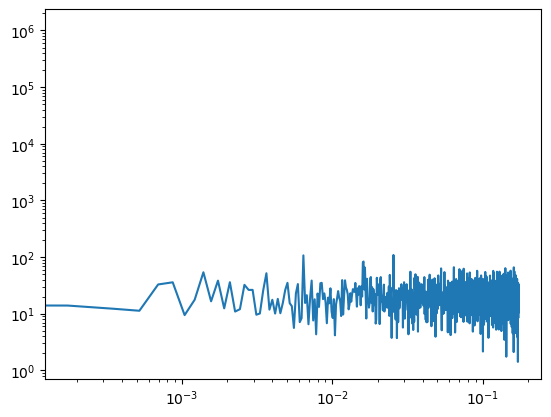

/var/folders/k4/ysx53zxj6zz2qrpwl9q0jvzh0000gp/T/ipykernel_49181/4171979791.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  events[i] = t


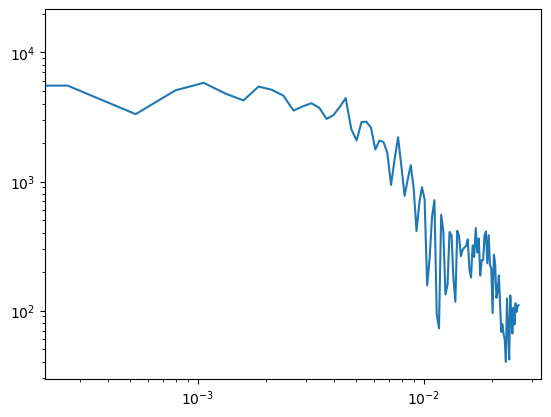

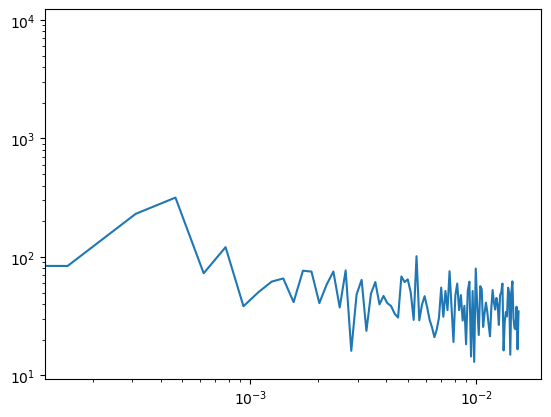

In [3]:
spikes = poisson_process(10, 8*60*60)
plot_power_spectrum(spikes, 0.00001, 100, 1000)
spikes = intermittent_poisson_process(50, 1, n_total_events=int(8*60*60))
plot_power_spectrum(spikes, 0.00001, 100, 100)
# print(spikes[-1])
# print(len(spikes)/spikes[-1])
spikes = intermittent_poisson_process(50, 1, n_total_events=int(8*60*60), z_on=-2.5, z_off=-2.5)
plot_power_spectrum(spikes, 0.00001, 100, 100)

In [4]:

print(spikes)


[1.06462818e-03 5.09752901e-01 1.34969231e+00 ... 3.22160461e+04
 3.22160546e+04 3.22160563e+04]


In [5]:


def read_file(file_path, min_rate=0.7, max_rate=5):

    print("Processing file " + file_path)

    times = []
    clusters = []
    res = []

    # read csv
    for i in range(1,9):
        times.append(pd.read_csv(f'{file_path}.res.{i}', engine='pyarrow', header=None).values.flatten())
        c = pd.read_csv(f'{file_path}.clu.{i}', engine='pyarrow', header=None).values.flatten()
        c = c[1:] # remove number of clusters
        clusters.append(c * (100**i))

    times = np.concatenate(times)
    clusters = np.concatenate(clusters)

    times = times / 20000
    T = np.max(times) 

    ids = np.unique(clusters)

    res = []

    for id in ids:
        spikes = times[clusters == id]

        rate = len(spikes)/spikes[-1]

        if rate > max_rate or rate < min_rate:
            continue

        res.append(spikes)

    return res

recording_file_path1 = '../fig4/h11_data/Achilles_11012013'
recording_file_path2 = '../fig4/h11_data/Buddy_06272013'
recording_file_path3 = '../fig4/h11_data/Cicero_09102014'
recording_file_path4 = '../fig4/h11_data/Gatsby_08022013'

spikes1 = read_file(recording_file_path1)

Processing file ../fig4/h11_data/Achilles_11012013


1.0449178267999382


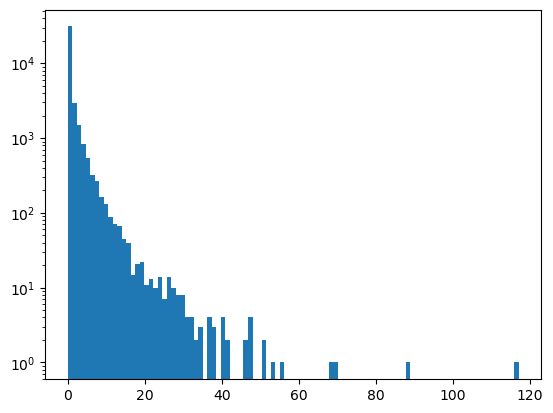

In [10]:
ISI = np.diff(spikes1[1])
# ISIs = [np.diff(s) for s in spikes1]
# ISIs = np.concatenate(ISIs)
print(1/np.mean(ISI))

plt.hist(ISI, bins=100)
plt.yscale('log')
plt.show()

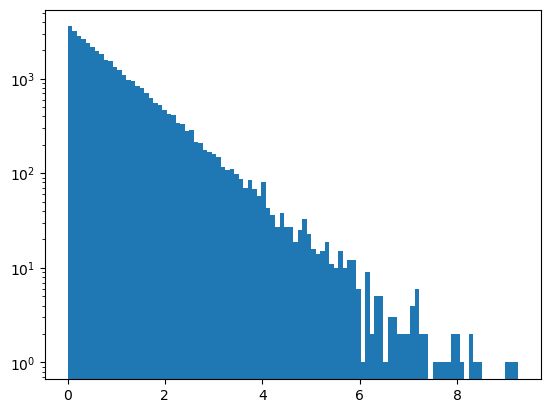

In [18]:
spikes = poisson_process(1/np.mean(ISI), np.sum(ISI))

ISIs = np.diff(spikes)
plt.hist(ISIs, bins=100)
plt.yscale('log')
plt.show()

/var/folders/k4/ysx53zxj6zz2qrpwl9q0jvzh0000gp/T/ipykernel_49181/4171979791.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  events[i] = t


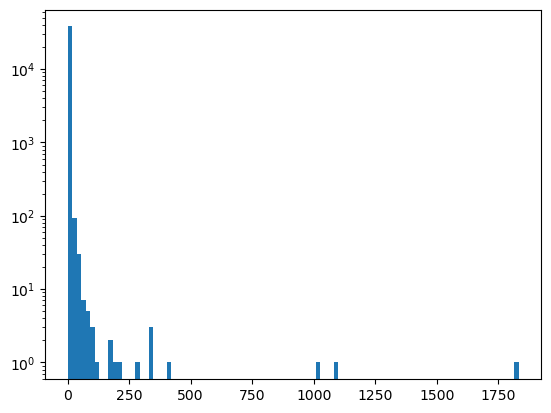

In [24]:
spikes = intermittent_poisson_process(1/np.mean(ISI), 1, n_total_events=len(ISI), z_on=-2.5, z_off=-2.5)

ISIs = np.diff(spikes)
plt.hist(ISIs, bins=100)
plt.yscale('log')
plt.show()